Author: Steven Vuong <br>
Last Edited: 20/05/2020

Here we pick off where we left off with the last preprocessing notebook. We have our processed raw tweets and want to apply another processing step. Firstly, we must open our processed data first.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pkl_savepath = "../../data/tweets_processed.pkl"
tweets_df = pd.read_pickle(pkl_savepath) 

We will drop the hashtags column as we have used this to create our predictive labels. It is possiblle that other features from this may be used to help predict other hashtags. For the time being, however, we will not consider it so. <br>
In addition, we will drop our original tweet_text column as we have the processed form of it.

In [3]:
tweets_df = tweets_df.drop(['tweet_text', 'tweet_hashtags'], axis=1)
tweets_df.head()

,tweet_creation_date,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_created_at,user_verified,processed_tweets,covid_hashtag
0,2020-05-17 14:36:25,111,0,32,2018-09-17 22:49:14,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False
1,2020-05-17 14:27:49,0,0,974,2016-06-28 19:39:16,False,kenya pastoralists face hunger conflict locust...,False
2,2020-05-17 14:21:52,36,0,27,2010-05-29 12:41:00,False,rt @drvandanashiva essentialcommoditiesact use...,False
3,2020-05-17 14:15:25,0,0,836,2009-03-27 01:52:54,False,man could literally hunger entire world choose...,False
4,2020-05-17 14:14:25,7,0,375,2014-07-04 16:19:51,False,rt presidential april year president express c...,False


In theory, we could use the date as a feature to consider. However, the tweets we have scraped ranges from a short time period.

In [4]:
# convert to datetime
tweets_df['tweet_creation_date'] = pd.to_datetime(tweets_df['tweet_creation_date'])
tweets_df['user_created_at'] = pd.to_datetime(tweets_df['user_created_at'])

In [5]:
earliest_tweet_time = tweets_df['tweet_creation_date'].min()
latest_tweet_time = tweets_df['tweet_creation_date'].max()

print(f"Earliest Tweet Scraped was at {earliest_tweet_time}")
print(f"Latest Tweet Scraped was at {latest_tweet_time}")

Earliest Tweet Scraped was at 2020-05-14 04:39:47
Latest Tweet Scraped was at 2020-05-17 14:36:25


We see the time difference is only 10 hours. Potentially we could make a column of 'hour_tweeted' out of it. However this does not cover all potential hours and there is not enough data. So we will make the decision to drop this column.

In [6]:
tweets_df = tweets_df.drop('tweet_creation_date', axis=1)

Look at user creation date now.

In [7]:
earliest_user_creation_timestamp = tweets_df['user_created_at'].min()
latest_user_creation_timestamp = tweets_df['user_created_at'].max()

print(f"Earliest User Created at {earliest_user_creation_timestamp}")
print(f"Latest User Created at {latest_user_creation_timestamp}")

Earliest User Created at 2007-05-11 08:38:01
Latest User Created at 2020-05-16 23:00:12


Quite a wide range. From 2007 all the way up until the day before scraping. Let's see if we can visualise this.

In [8]:
# first cast a column of ones (will use for counting)
tweets_df['dummy_ones'] = np.ones(len(tweets_df))

# make column for user created month/year/day_of_week/hour
tweets_df['user_created_year'] = tweets_df['user_created_at'].map(lambda x: x.year)
tweets_df['user_created_month'] = tweets_df['user_created_at'].map(lambda x: x.month)
tweets_df['user_created_day_of_week'] = tweets_df['user_created_at'].map(lambda x: x.dayofweek)
tweets_df['user_created_hour'] = tweets_df['user_created_at'].map(lambda x: x.hour)

tweets_df.head()

,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_created_at,user_verified,processed_tweets,covid_hashtag,dummy_ones,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,111,0,32,2018-09-17 22:49:14,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False,1.0,2018,9,0,22
1,0,0,974,2016-06-28 19:39:16,False,kenya pastoralists face hunger conflict locust...,False,1.0,2016,6,1,19
2,36,0,27,2010-05-29 12:41:00,False,rt @drvandanashiva essentialcommoditiesact use...,False,1.0,2010,5,5,12
3,0,0,836,2009-03-27 01:52:54,False,man could literally hunger entire world choose...,False,1.0,2009,3,4,1
4,7,0,375,2014-07-04 16:19:51,False,rt presidential april year president express c...,False,1.0,2014,7,4,16


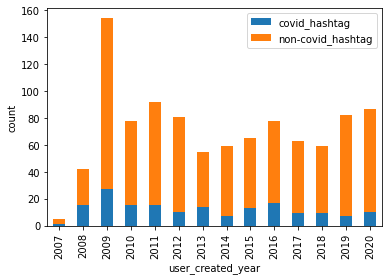

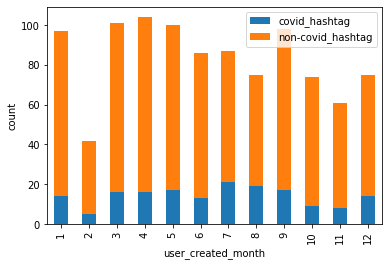

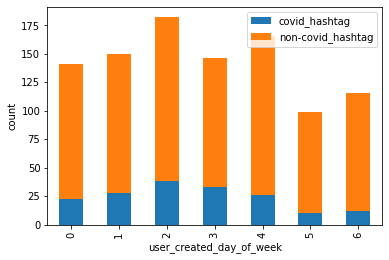

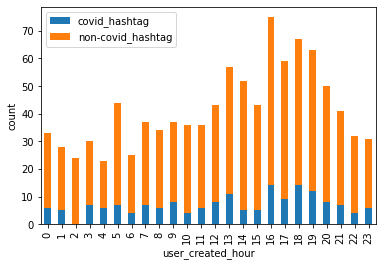

In [45]:
def barplot_groupby_labels_count(
    dataframe: pd.DataFrame, 
    groupby_category: str, 
    count_column: str,
    label_column:str
    ):
    
    groupby_year = dataframe.groupby(groupby_category)[count_column].sum()
    groupby_label = dataframe.groupby(groupby_category)[label_column].sum() # num true

    groupby_df = pd.DataFrame([groupby_year, groupby_label]).T
    groupby_df[f'non-{label_column}'] = groupby_df[count_column] - groupby_df[label_column]

    groupby_df[[label_column, f'non-{label_column}',]].plot(kind='bar', stacked=True)
    plt.ylabel('count')
    plt.show()
    

group_by_categories = ['user_created_year', 'user_created_month', 'user_created_day_of_week', 'user_created_hour']

for category in group_by_categories:
    barplot_groupby_labels_count(tweets_df, category, 'dummy_ones', 'covid_hashtag')
    

Seems there is not much visible correlation between covid hashtag and when the user account was created. Nonetheless, we have engineered some columns and it may come in handly later for modelling, albeit unlikely but could be worth investigation. So drop original user created datetime column and proceed with processing the original tweets.

In [46]:
tweets_df = tweets_df.drop(['dummy_ones', 'user_created_at'], axis=1)

We want to remove frequent and rare words from our processed tweets. First we should take a look at what words are frequent/rare to see what portion we may want to skim off.

Ref:
-  https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing#Removal-of-Frequent-words

In [ ]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

In [47]:
tweets_df.head()

,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_verified,processed_tweets,covid_hashtag,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,111,0,32,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False,2018,9,0,22
1,0,0,974,False,kenya pastoralists face hunger conflict locust...,False,2016,6,1,19
2,36,0,27,False,rt @drvandanashiva essentialcommoditiesact use...,False,2010,5,5,12
3,0,0,836,False,man could literally hunger entire world choose...,False,2009,3,4,1
4,7,0,375,False,rt presidential april year president express c...,False,2014,7,4,16
